# Pleiades Work-Precision Diagrams

https://benchmarks.sciml.ai/html/NonStiffODE/Pleiades_wpd.html

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates

## Initial value problem: Pleiades

In [2]:
f = (du,u,p,t) -> begin
  @inbounds begin
  x = view(u,1:7)   # x
  y = view(u,8:14)  # y
  v = view(u,15:21) # x′
  w = view(u,22:28) # y′
  du[1:7] .= v
  du[8:14].= w
  for i in 15:28
    du[i] = zero(u[1])
  end
  for i=1:7,j=1:7
    if i != j
      r = ((x[i]-x[j])^2 + (y[i] - y[j])^2)^(3/2)
      du[14+i] += j*(x[j] - x[i])/r
      du[21+i] += j*(y[j] - y[i])/r
    end
  end
  end
end

prob = ODEProblem(f,[3.0,3.0,-1.0,-3.0,2.0,-2.0,2.0,
                     3.0,-3.0,2.0,0,0,-4.0,4.0,    
                     0,0,0,0,0,1.75,-1.5,
                     0,0,0,-1.25,1,0,0],
                 (0.0,3.0));


In [3]:
setprecision(BigFloat, 256)
prob128 = ODEProblem(f,BigFloat.([3.0,3.0,-1.0,-3.0,2.0,-2.0,2.0,
                     3.0,-3.0,2.0,0,0,-4.0,4.0,    
                     0,0,0,0,0,1.75,-1.5,
                     0,0,0,-1.25,1,0,0]),
                     (BigFloat(0.0),BigFloat(3.0)));
(typeof(prob128.u0),typeof(prob128.tspan))


(Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

## Vern9

In [4]:
sol = @time (solve(prob128,Vern9(),abstol=1/10^20,reltol=1/10^20,maxiters=1000000))
test_sol = TestSolution(sol);

 56.873613 seconds (131.56 M allocations: 6.214 GiB, 5.90% gc time)


In [5]:
plot(sol)

## Integration with IRKGL16 (Adaptive-step)

In [24]:
(sol1,iters1,steps1) = @time(solve(prob,IRKGL16(), reltol=1e-12, abstol=1e-12,
                                   adaptive=true,myoutputs=true));

  0.038921 seconds (35.32 k allocations: 1.963 MiB)


In [7]:
sum(iters1)/sol1.destats.naccept

9.091836734693878

In [8]:
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  8186
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          98
Number of rejected steps:                          19

## Integration with IRKGL162 (Adaptive-step)

In [19]:
(sol2,iters2,steps2) = @time(solve(prob,IRKGL162(), reltol=1e-12, abstol=1e-12,
                                   adaptive=true,myoutputs=true));

  0.044467 seconds (40.11 k allocations: 2.182 MiB)


In [20]:
sum(iters2)/sol2.destats.naccept

11.795918367346939

In [21]:
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  9383
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          98
Number of rejected steps:                          19

### Plots IRKGL16

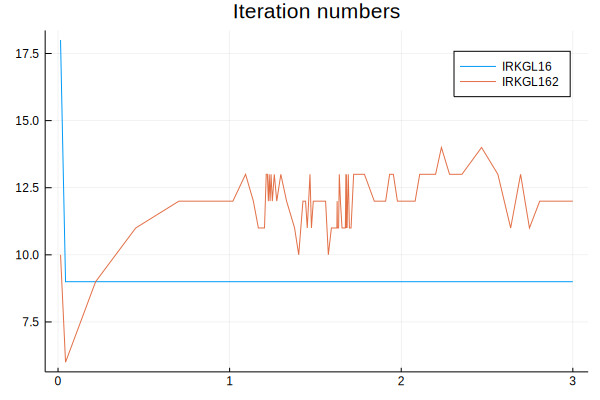

In [25]:
plot(sol1.t[2:end],iters1[2:end], title="Iteration numbers", label="IRKGL16")
plot!(sol2.t[2:end],iters2[2:end],label="IRKGL162")

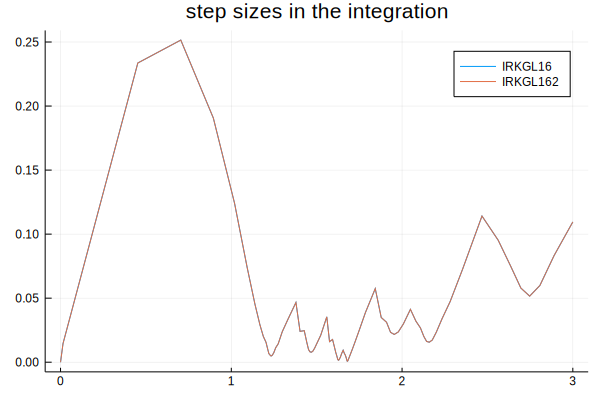

In [26]:
plot(sol1.t,steps1, title="step sizes in the integration", label="IRKGL16")
plot!(sol2.t,steps2,label="IRKGL162")

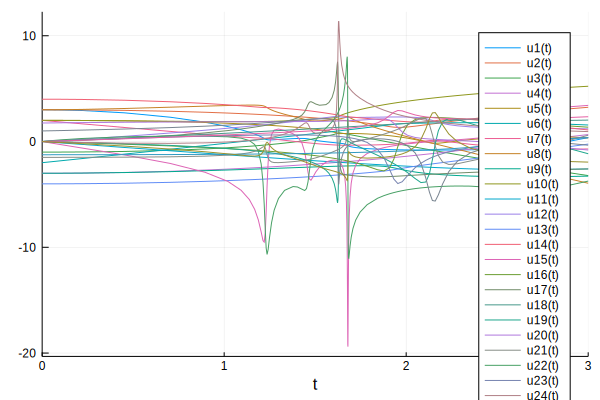

In [32]:
plot(sol1)

## Energy Error

In [29]:
u0128=prob128.u0
Gm128=BigFloat.([1,2,3,4,5,6,7])
(typeof(u0128),typeof(Gm128),length(Gm128))

(Array{BigFloat,1}, Array{BigFloat,1}, 7)

In [30]:
function NbodyEnergy(u, Gm)
"""    
     Nbody problem Hamiltonian (Cartesian Coordinates)     
"""    
    
    # Declarations 
    
    dim=2   
    nbody=length(Gm)
    
    # Implementation

 @inbounds begin
    x = view(u,1:7)   # x
    y = view(u,8:14)  # y
    v = view(u,15:21) # x′
    w = view(u,22:28) # y′
   
    H=0.
    P=0.
    
    for i in 1:nbody
        H+=Gm[i]*(v[i]*v[i]+w[i]*w[i])                       
        for j in i+1:nbody           
            r = ((x[i]-x[j])^2+(y[i]-y[j])^2)^(1/2)
            P+=(Gm[i]/r)*Gm[j]
        end
    end
    
    return(H/2-P)
    end
        
end

NbodyEnergy (generic function with 1 method)

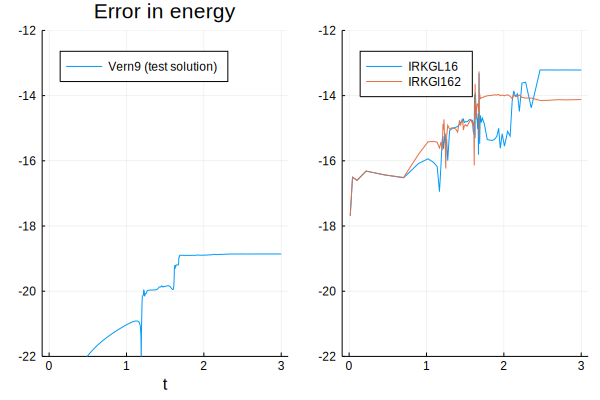

In [34]:
E0=NbodyEnergy(u0128,Gm128)
end1=length(steps1)

ulist = sol.u
tlist = sol.t
EnergyErrors=[NbodyEnergy(BigFloat.(sol.u[j]),Gm128)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(BigFloat.(sol1.u[j]),Gm128)/E0-1 for j in 1:length(tlist1)]

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]
EnergyErrors2=[NbodyEnergy(BigFloat.(sol2.u[j]),Gm128)/E0-1 for j in 1:length(tlist2)]

ylimit1=-22
ylimit2=-12

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)),
    ylims=(ylimit1,ylimit2),
   xlabel="t", title="Error in energy", label="Vern9 (test solution)", legend=:topleft)
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
        ylims=(ylimit1,ylimit2),
    label="IRKGL16", legend=:topleft)
p2=plot!(tlist2[1:end],log10.(abs.(EnergyErrors2)),
        ylims=(ylimit1,ylimit2),
        label="IRKGl162")
plot(p1,p2,layout=2)

In [43]:
(Float32(maximum(abs.(EnergyErrors))),Float32(maximum(abs.(EnergyErrors1))),Float32(maximum(abs.(EnergyErrors2))))

(1.3895315f-19, 6.123634f-14, 5.4979452f-14)

## Global error

In [44]:
# IRGL16
apr = appxtrue(sol1,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 2.353048873003111883236335330000045438665304450580125759386605625064106707623673e-11,:L2 => 0.00970148886220856444462533997266797823294559876003679119236690652112019796148945,:final => 1.031403050416872057589343724818190385252738987212341828172625456406061779063384e-13,:l2 => 9.487162703965454000870784858941764414455827717262099099238483242345747835616458e-13,:L∞ => 0.1054979107487970869726592804749500797234283994267305922680099489648917069109444)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 2.35305e-11
  :L2    => 0.00970149
  :final => 1.0314e-13
  :l2    => 9.48716e-13
  :L∞    => 0.105498

In [46]:
err1=Float32(norm(sol1.u[end]-sol.u[end]))
err2=Float32(norm(sol2.u[end]-sol.u[end]))
(err1,err2)

(1.1902097f-12, 6.948551f-13)

## High Order


In [ ]:
now()

In [47]:
abstols = 1.0 ./ 10.0 .^ (8:16)
reltols = 1.0 ./ 10.0 .^ (8:16);

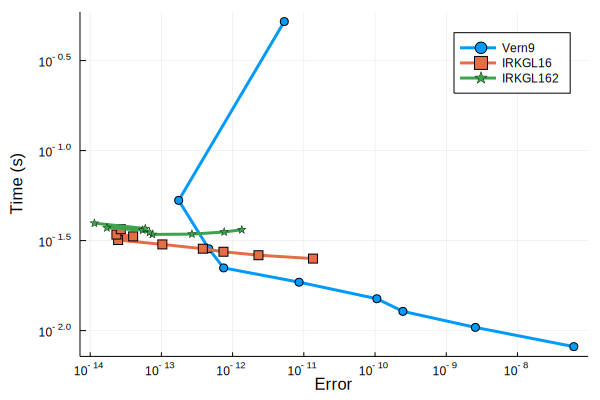

In [49]:
setups = [
#    Dict(:alg=>DP8())
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16())
          Dict(:alg=>IRKGL162())
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=100,maxiters=100000)
plot(wp)

In [ ]:
now()

In [17]:
fieldnames(typeof(wp))

(:wps, :N, :abstols, :reltols, :prob, :setups, :names, :error_estimate, :numruns)

In [18]:
wp.wps

4-element Array{WorkPrecision,1}:
 Name: DP8
Times: [0.008747418, 0.010994348, 0.01386557, 0.017433846, 0.021060167, 0.024942322, 0.032725971]
Errors: [4.2100159898766593e-7, 8.560595967019905e-8, 6.521167676645932e-9, 4.853195522660969e-10, 5.06831495008514e-11, 3.5347382697211944e-12, 8.201959907497239e-13]
          
 Name: Vern9
Times: [0.008077713, 0.010040416, 0.012365268, 0.015476505, 0.018465848, 0.022359106, 0.02866781]
Errors: [6.185112457223087e-8, 2.566893911142516e-9, 2.4618427209374537e-10, 1.0606496779519642e-10, 8.570155389698514e-12, 7.484166204596721e-13, 4.630901868278207e-13]
      
 Name: Vern8
Times: [0.007433215, 0.009297932, 0.012112073, 0.014803361, 0.018178948, 0.023185507, 0.037974713]
Errors: [3.202244203565078e-7, 1.8075947529577322e-8, 1.1426393516277476e-9, 9.033021961413167e-11, 9.520647056279855e-12, 9.09708594018338e-13, 8.587338003450794e-13]
       
 Name: IRKGL16
Times: [0.03611126, 0.035048178, 0.034202276, 0.034399099, 0.035216487, 0.035677799, 0.